In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import radviz
import numpy as np
import sys

data = pd.read_table("/content/drive/My Drive/machine learning/rectangle.txt",header=None, index_col=False, names=['c1', 'c2', 'label'], delimiter=r"\s+")
data

Mounted at /content/drive


,c1,c2,label
0,1.75,2.47,1
1,2.00,3.83,-1
2,2.65,1.49,1
3,3.79,2.58,-1
4,3.56,0.97,-1
...,...,...,...
145,0.71,1.74,-1
146,2.14,1.43,1
147,3.66,1.97,-1
148,0.06,3.44,-1


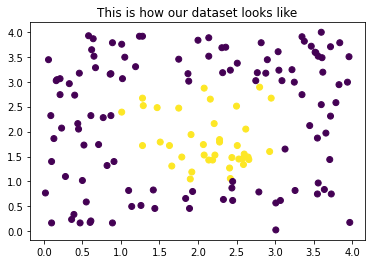

In [2]:
x,y,c = np.loadtxt('/content/drive/My Drive/machine learning/rectangle.txt', unpack=True)
plt.scatter(x,y,c=c)
plt.title("This is how our dataset looks like")
plt.show()

Classes for the rules

In [3]:
class Rule:
    # a linear line defined as y = m*x + c
    def __init__(self, m, c, direction=1, is_vertical=False, x=0, line_weight=0):
        self.m = m
        self.c = c
        self.direction = direction
        self.is_vertical = is_vertical
        self.line_weight = line_weight
        self.x = x

    # the classification is bidirectional
    # hence we can choose direction (1/-1)
    def classify(self, point):
        if (self.is_vertical):
            if point[0] >= self.x:
                classification = 1
            else:
                classification = -1
        else:
            if point[1] >= self.m * point[0] + self.c:
                classification = 1
            else:
                classification = -1

        return classification * self.direction

    def set_weight(self, line_weight):
        self.line_weight = line_weight

    def get_weight(self):
        return self.line_weight

# after we got weight for every rule
# we want to classify every point 
# by summing the rules and their weights
class BoostedLines:
    def __init__(self, rules):
        self.rules = rules

    def classify(self, point):
        vote = 0
        for rule in self.rules:
            vote += rule.get_weight() * rule.classify(point)

        return np.sign(vote)

Find all possible lines.

In our case we split the data to half train and half test and we find the lines only on the train so we have 5550 lines

In [4]:
def create_lines(data):
    lines = list()
    for i1, p1 in enumerate(data.values):
        for i2, p2 in enumerate(data.values):
            if i1 == i2 or i2 < i1:
                continue
            x0 = p1[0]
            x1 = p2[0]
            y0 = p1[1]
            y1 = p2[1]
            # median = [np.average([x0, x1]), np.average([y0, y1])]
            for rule_direction in [1, -1]:
                rule = None
                if x0 - x1 == 0:  # parallel to Y-axis
                    # rule = VerticalLineRule(x0, rule_direction)#median[0]
                    rule = Rule(0, 0, rule_direction, True, x0)
                elif y0 - y1 == 0:  # parallel to X-axis
                    rule = Rule(0, y0, rule_direction)  # median[1]
                else:
                    m = (y0 - y1) / (x0 - x1)
                    # new_m = -(1 / m)
                    c = y0 - m * x0
                    # new_y = median[1] - new_m * median[0]
                    rule = Rule(m, c, rule_direction)
                if rule not in lines:
                    lines.append(rule)

    return lines

Run the algorithm

In [5]:
class Adaboost:
    def __init__(self, data, best_rules_num=8, iteration_num=10):
        self.data = data
        self.train_data= data
        self.test_data = data
        self.best_rules_num = best_rules_num
        self.iteration_num = iteration_num
        self.best_rules = list()
        self.points_weights = np.full(75, 1 / 75)
        self.rules = list()

    def run(self):
        results = np.zeros((self.best_rules_num, 2))
        for i in range(self.iteration_num):
            print("Iteration: ", i)
            shuffled_data = self.data.sample(frac=1).reset_index(drop=True)
            self.train_data, self.test_data = np.vsplit(shuffled_data, 2)
            self.best_rules = list()
            self.points_weights = np.full(len(self.train_data.index), 1 / len(self.train_data.index))
            self.rules = create_lines(self.train_data)
            self.adaboost_algorithm()
            true_errors, empirical_errors = self.result()
            results[:, 0] += true_errors
            results[:, 1] += empirical_errors

        # compute average error
        results /= self.iteration_num
        plt.scatter(self.train_data.c1, self.train_data.c2, c=self.train_data.label)
        plt.title("Train Data")
        plt.show()
        return self.best_rules, results

    def result(self):
        # sum train error and test_error
        empirical_errors = list()
        true_errors = list()
        for k in range(1, self.best_rules_num + 1):
            boosted_lines = BoostedLines(self.best_rules[:k])
            test_results = self.test_data.apply(lambda row: boosted_lines.classify(row) == row[2], axis=1,result_type='reduce')
            train_results = self.train_data.apply(lambda row: boosted_lines.classify(row) == row[2], axis=1, result_type='reduce')
            true_error = len(test_results[test_results == False]) / len(test_results)
            empirical_error = len(train_results[train_results == False]) / len(train_results)
            true_errors.append(true_error)
            empirical_errors.append(empirical_error)

        return (true_errors, empirical_errors)

    def adaboost_algorithm(self, to_find_best=False):
        for i in range(self.best_rules_num):
            min_line = self.rules[0]
            min = sys.maxsize
            for line in self.rules:
                # if line.get_weight() != 0:
                #     continue
                error = 0
                results = self.train_data.apply(lambda row: line.classify(row) == row[2], axis=1, result_type='reduce')
                for index in results[results == False].index:
                    error += self.points_weights[index]
                if error <= min:
                    min = error
                    min_line = line
            weight = 0.5 * np.log((1 - min) / (min))
            min_line.set_weight(weight)
            self.best_rules.append(min_line)
            for index, point in self.train_data.iterrows():
                self.points_weights[index] *= (np.e ** (-weight * min_line.classify(point) * point[2]))
            # normalize
            self.points_weights /= np.sum(self.points_weights)


Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Itera

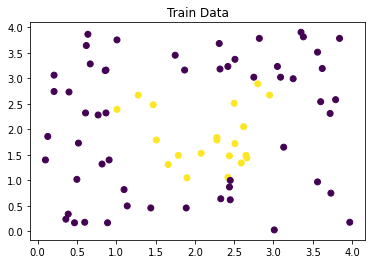

In [6]:
# we need 8 lines and 100 iterations
run_data = Adaboost(data, 8, 100)
best_lines, results = run_data.run()

This is the last train data after the last iteration ^

Print the average results after 100 iterations

In [7]:
print(results)

[[0.30653333 0.25306667]
 [0.39426667 0.33933333]
 [0.268      0.15986667]
 [0.27893333 0.17853333]
 [0.19786667 0.06706667]
 [0.2368     0.10266667]
 [0.18013333 0.05      ]
 [0.18133333 0.05746667]]


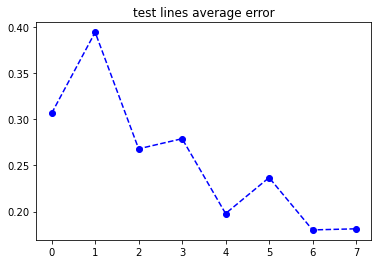

In [29]:
plt.title("test lines average error")
plt.plot(results[:, 0], '--bo')
plt.show()

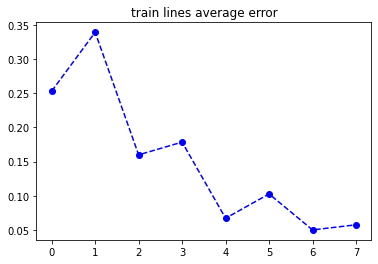

In [30]:
plt.title("train lines average error")
plt.plot(results[:, 1], '--bo')
plt.show()

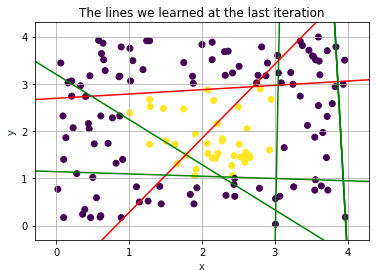

In [31]:
x,y,c = np.loadtxt('/content/drive/My Drive/machine learning/rectangle.txt', unpack=True)
plt.scatter(x,y,c=c)
space = np.linspace(-5,5,100)
plt.ylim((-0.3, 4.3))
plt.xlim((-0.3, 4.3))
plt.title("The lines we learned at the last iteration")
plt.plot(space, best_lines[0].m*space+best_lines[0].c, '-g')
plt.plot(space, best_lines[1].m*space+best_lines[1].c, '-r')
plt.plot(space, best_lines[2].m*space+best_lines[2].c, '-g')
plt.plot(space, best_lines[3].m*space+best_lines[3].c, '-g')
plt.plot(space, best_lines[4].m*space+best_lines[4].c, '-g')
plt.plot(space, best_lines[5].m*space+best_lines[5].c, '-r')
plt.plot(space, best_lines[6].m*space+best_lines[6].c, '-g')
plt.plot(space, best_lines[7].m*space+best_lines[7].c, '-g')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.grid()
plt.show()

green lines = direction -1

red lines = direction 1



```
            | train error average | test error average
---------------------------------------------------------
one line    |     0.253           | 0.306
two lines   |     0.339           | 0.394
three lines |     0.159           | 0.268
four lines  |     0.178           | 0.278
five lines  |     0.067           | 0.197
six lines   |     0.102           | 0.236
seven lines |     0.05            | 0.18
eight lines |     0.057           | 0.181


```
1. it seems that in both the train and the test there is some jump in the error every even rule, as we can see in the graph above, the reason for that is that after a rule is learned the weights of the points we missclassified are high so we need a line to cover the missclassified points but since all yellow points are in the middle its hard to classify them correctly without missclassifing other points.
also there are some rules that we learn more than one time because it's important rule.

2. it doesnt seem that we have overfitting here, the error graphs of the train and test have the same pattern, which imply that we don't have overfitting, also the test error is not that far from the train error.
it's all depend on the split of the train and test, the more similar the train set is to the test set the closer the error will be.

python v3.7.9